In [94]:
import pandas as pd
import numpy as np
import datetime
from scorepi import *
from epiweeks import Week
import matplotlib.pyplot as plt
from collections import defaultdict
import seaborn as sns

In [95]:
import warnings
warnings.filterwarnings('ignore')

In [200]:
locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})

In [201]:
model = "MOBS_NEU-GLEAM_COVID"
rd=12
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

loclist = list(predictions.location.unique())
loclist.remove('US')

In [202]:
rd = 12
start_week = Week(2022,2)
end_week = Week(2022,13)
max_date = None
#max_date = datetime.datetime(2022, 3, 15)
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]

In [140]:
a = pd.read_parquet(f'./dat/Ensemble_rd12.pq')
a.target.unique()

array(['1 wk ahead cum case', '1 wk ahead cum death',
       '1 wk ahead cum hosp', '1 wk ahead inc case',
       '1 wk ahead inc death', '1 wk ahead inc hosp',
       '10 wk ahead cum case', '10 wk ahead cum death',
       '10 wk ahead cum hosp', '10 wk ahead inc case',
       '10 wk ahead inc death', '10 wk ahead inc hosp',
       '11 wk ahead cum case', '11 wk ahead cum death',
       '11 wk ahead cum hosp', '11 wk ahead inc case',
       '11 wk ahead inc death', '11 wk ahead inc hosp',
       '12 wk ahead cum case', '12 wk ahead cum death',
       '12 wk ahead cum hosp', '12 wk ahead inc case',
       '12 wk ahead inc death', '12 wk ahead inc hosp',
       '2 wk ahead cum case', '2 wk ahead cum death',
       '2 wk ahead cum hosp', '2 wk ahead inc case',
       '2 wk ahead inc death', '2 wk ahead inc hosp',
       '3 wk ahead cum case', '3 wk ahead cum death',
       '3 wk ahead cum hosp', '3 wk ahead inc case',
       '3 wk ahead inc death', '3 wk ahead inc hosp',
       '4 wk ahe

In [10]:
#loclist = ['01']

In [155]:
median_ensembles = dict()
extreme_ensembles = dict()

df = pd.DataFrame(columns=['Model', 'WIS','50% Coverage','95% Coverage', 'Location', 'Population','Label'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    target = 'death'
    #target = 'hosp'
    #target = 'case'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    
    
    

    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location != 'US']
            predictions = predictions.astype({'location':'int'})
            
            
            locations = locations[locations.location != 'US']
            locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = int(target_location)
            
            pred = predictions[predictions['location'] == int(target_location)].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
            
            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Median aggregate", "Extreme Aggregate"]

        


            aggregated_scores = dict()
            for label,predictions in zip(labels,predictions_list):
                d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
                
                
                aggregated_scores[label] = d

            aggregated_data = defaultdict(list)
            for label in ["Median aggregate"]:
                aggregated_data['Case'] += [label]
                aggregated_data['WIS'] += [aggregated_scores[label]['wis_mean']]
                aggregated_data['Cov50'] += [aggregated_scores[label]['50_cov']]
                aggregated_data['Cov95'] += [aggregated_scores[label]['95_cov']]

                agg_data_df = pd.DataFrame(aggregated_data)
                agg_data_df['Model'] = model
                wisval = agg_data_df.WIS[0]
                cov50val = agg_data_df.Cov50[0]
                cov95val = agg_data_df.Cov95[0]

            
            locname = list(pred.location_name.unique())[0]
            popsize = list(pred.population.unique())[0]


            new_row = {'Model':model, 'WIS':wisval,'50% Coverage':cov50val, '95% Coverage':cov95val,
                       'Location': locname, 'Population': popsize, 'Label':label}
 
            df = df.append(new_row, ignore_index=True)
            
            
  
        except Exception as e:
            print(e)    
    


There are no predictions for model NCSU-COVSIM at location 01
There are no predictions for model NotreDame-FRED at location 01
There are no predictions for model UTA-ImmunoSEIRS at location 01
There are no predictions for model NCSU-COVSIM at location 02
There are no predictions for model NotreDame-FRED at location 02
There are no predictions for model UTA-ImmunoSEIRS at location 02
There are no predictions for model NCSU-COVSIM at location 04
There are no predictions for model NotreDame-FRED at location 04
There are no predictions for model UTA-ImmunoSEIRS at location 04
There are no predictions for model NCSU-COVSIM at location 05
There are no predictions for model NotreDame-FRED at location 05
There are no predictions for model UTA-ImmunoSEIRS at location 05
There are no predictions for model NCSU-COVSIM at location 06
There are no predictions for model NotreDame-FRED at location 06
There are no predictions for model NCSU-COVSIM at location 08
There are no predictions for model Notr

There are no predictions for model UTA-ImmunoSEIRS at location 49
There are no predictions for model NCSU-COVSIM at location 50
There are no predictions for model NotreDame-FRED at location 50
There are no predictions for model UTA-ImmunoSEIRS at location 50
There are no predictions for model NCSU-COVSIM at location 51
There are no predictions for model NotreDame-FRED at location 51
There are no predictions for model UTA-ImmunoSEIRS at location 51
There are no predictions for model NCSU-COVSIM at location 53
There are no predictions for model NotreDame-FRED at location 53
There are no predictions for model UTA-ImmunoSEIRS at location 53
There are no predictions for model NCSU-COVSIM at location 54
There are no predictions for model NotreDame-FRED at location 54
There are no predictions for model UTA-ImmunoSEIRS at location 54
There are no predictions for model NCSU-COVSIM at location 55
There are no predictions for model NotreDame-FRED at location 55
There are no predictions for model 

In [157]:
pred

,target,location,scenario_name,scenario_id,quantile,value,target_end_date,model_projection_date,type,abbreviation,location_name,population
104832,1 wk ahead inc death,56,optSev_highIE,A-2022-01-09,0.0,6.285426,2022-01-15,2022-01-09,quantile,WY,Wyoming,578759
104833,2 wk ahead inc death,56,optSev_highIE,A-2022-01-09,0.0,1.315014,2022-01-22,2022-01-09,quantile,WY,Wyoming,578759
104834,3 wk ahead inc death,56,optSev_highIE,A-2022-01-09,0.0,0.261968,2022-01-29,2022-01-09,quantile,WY,Wyoming,578759
104835,4 wk ahead inc death,56,optSev_highIE,A-2022-01-09,0.0,0.046024,2022-02-05,2022-01-09,quantile,WY,Wyoming,578759
104836,5 wk ahead inc death,56,optSev_highIE,A-2022-01-09,0.0,0.008198,2022-02-12,2022-01-09,quantile,WY,Wyoming,578759
...,...,...,...,...,...,...,...,...,...,...,...,...
112255,8 wk ahead inc death,56,pessSev_lowIE,D-2022-01-09,NaN,0.100613,2022-03-05,2022-01-09,point,WY,Wyoming,578759
112256,9 wk ahead inc death,56,pessSev_lowIE,D-2022-01-09,NaN,0.044625,2022-03-12,2022-01-09,point,WY,Wyoming,578759
112257,10 wk ahead inc death,56,pessSev_lowIE,D-2022-01-09,NaN,0.020693,2022-03-19,2022-01-09,point,WY,Wyoming,578759
112258,11 wk ahead inc death,56,pessSev_lowIE,D-2022-01-09,NaN,0.009850,2022-03-26,2022-01-09,point,WY,Wyoming,578759


In [9]:
aggregated_scores['Median aggregate']

{'10_cov': 0.0,
 '20_cov': 0.0,
 '30_cov': 0.0,
 '40_cov': 0.0,
 '50_cov': 0.0,
 '60_cov': 0.0,
 '70_cov': 0.0,
 '80_cov': 0.1111111111111111,
 '90_cov': 0.1111111111111111,
 '95_cov': 0.1111111111111111,
 '98_cov': 0.1111111111111111,
 'nb_t_match': 9,
 'wis_total': 23757.537315217392,
 'wis_mean': 2639.7263683574884,
 'point_absolute_error_total': 33612.5,
 'point_absolute_error_mean': 3734.722222222222,
 '0_underprediction_wis_fraction': 0.03625439817112723,
 '0_overprediction_wis_fraction': 0.025259260592745716,
 '10_dispersion_wis_fraction': 0.007066238003378759,
 '10_underprediction_wis_fraction': 0.06593486434288978,
 '10_overprediction_wis_fraction': 0.048641222229448874,
 '20_dispersion_wis_fraction': 0.012842349972874721,
 '20_underprediction_wis_fraction': 0.05928406886511425,
 '20_overprediction_wis_fraction': 0.04627474213580619,
 '30_dispersion_wis_fraction': 0.01633835718259213,
 '30_underprediction_wis_fraction': 0.054877961469356695,
 '30_overprediction_wis_fraction': 

In [158]:
median_ensembles_all_death = median_ensembles
extreme_ensembles_all_death = extreme_ensembles

df_all_death = df

In [159]:
df_all_hosp.to_pickle('df_all_hosp.pkl') 
df_all_death.to_pickle('df_all_death.pkl')
df_all_case.to_pickle('df_all_case.pkl')

In [144]:
def check_coherence(predictions): 
    quantiles = predictions['quantile'].dropna().unique()
    qlist = quantiles[quantiles < 0.5]
    qlist_ = list(reversed(quantiles[quantiles > 0.5]))
    for i,q in enumerate(qlist):
        low = predictions[(predictions['quantile'] == q) & (predictions['location'] == 'US')].sort_values(
            by=['target_end_date'])
        up = predictions[(predictions['quantile'] == qlist_[i]) & (predictions['location'] == 'US')].sort_values(
            by=['target_end_date'])
        if not all((up['value'].to_numpy() - low['value'].to_numpy()) > 0):
            raise RuntimeError(f"quantile {q} and {qlist_[i]} now well conditioned")

In [448]:
df_all_case.head(10)

,Model,WIS,50% Coverage,95% Coverage,Location,Population
0,Ensemble,13296.525920,0.555556,0.888889,Alabama,4903185
1,Ensemble_LOP,12168.517187,0.888889,1.000000,Alabama,4903185
2,Ensemble_LOP_untrimmed,14887.529427,0.888889,1.000000,Alabama,4903185
3,JHU_IDD-CovidSP,13540.737598,0.444444,1.000000,Alabama,4903185
4,MOBS_NEU-GLEAM_COVID,8999.829219,0.333333,0.666667,Alabama,4903185
5,UNCC-hierbin,26562.129311,0.000000,0.111111,Alabama,4903185
6,USC-SIkJalpha,64207.627879,0.111111,0.222222,Alabama,4903185
7,UVA-EpiHiper,37023.165824,0.111111,0.444444,Alabama,4903185
8,UVA-adaptive,23054.223645,0.111111,0.222222,Alabama,4903185
9,Ensemble,1805.620254,0.555556,1.000000,Alaska,731545


In [814]:
df_all_case.head(10)

,Model,WIS,50% Coverage,95% Coverage,Location,Population,Label
0,Ensemble,12953.849139,0.666667,0.888889,Alabama,4903185,Median aggregate
1,Ensemble_LOP,11988.337519,0.888889,1.000000,Alabama,4903185,Median aggregate
2,Ensemble_LOP_untrimmed,14195.242007,0.888889,1.000000,Alabama,4903185,Median aggregate
3,JHU_IDD-CovidSP,11580.590399,0.888889,1.000000,Alabama,4903185,Median aggregate
4,MOBS_NEU-GLEAM_COVID,11230.877077,0.333333,0.555556,Alabama,4903185,Median aggregate
5,UNCC-hierbin,26739.328206,0.000000,0.111111,Alabama,4903185,Median aggregate
6,USC-SIkJalpha,57416.689944,0.000000,0.222222,Alabama,4903185,Median aggregate
7,UVA-EpiHiper,34138.202060,0.111111,0.444444,Alabama,4903185,Median aggregate
8,UVA-adaptive,21758.091058,0.111111,0.222222,Alabama,4903185,Median aggregate
9,Ensemble,1816.181579,0.555556,1.000000,Alaska,731545,Median aggregate


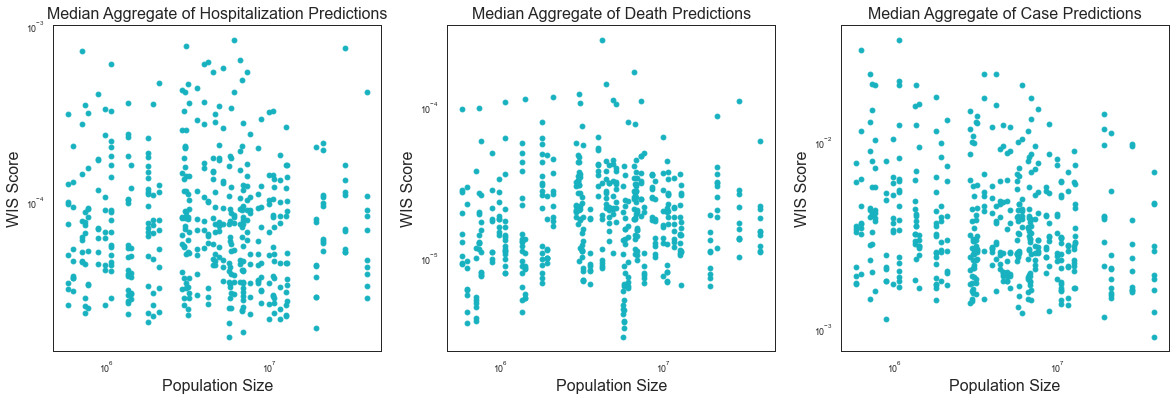

In [160]:
plt.figure(figsize=(20,6))
plt.subplot(1,3,1)
plt.loglog(df_all_hosp['Population'],df_all_hosp['WIS']/df_all_hosp['Population'], 'o',  color = '#17B1BF')
plt.xlabel('Population Size', fontsize=16)
plt.ylabel('WIS Score', fontsize=16)
plt.title('Median Aggregate of Hospitalization Predictions', fontsize=16)


plt.subplot(1,3,2)
plt.loglog(df_all_death['Population'],df_all_death['WIS']/df_all_death['Population'], 'o', color = '#17B1BF')
plt.xlabel('Population Size', fontsize=16)
plt.ylabel('WIS Score', fontsize=16)
plt.title('Median Aggregate of Death Predictions', fontsize=16)


plt.subplot(1,3,3)
plt.loglog(df_all_case['Population'],df_all_case['WIS']/df_all_case['Population'], 'o', color = '#17B1BF')
plt.xlabel('Population Size', fontsize=16)
plt.ylabel('WIS Score', fontsize=16)
plt.title('Median Aggregate of Case Predictions', fontsize=16)


plt.show()

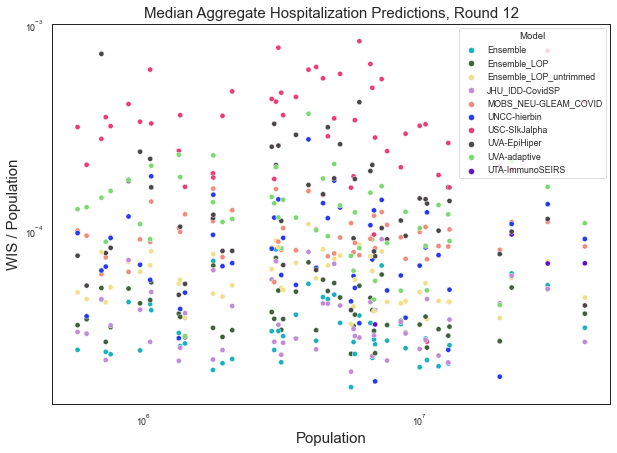

In [161]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_all_hosp,x=df_all_hosp['Population'],
                y=df_all_hosp['WIS']/df_all_hosp['Population']
                , hue='Model' , s=27).set(title='Median Aggregate Hospitalization Predictions, Round 12')
ax.set( ylabel='WIS / Population')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('wispop_hosp.pdf')
plt.show()

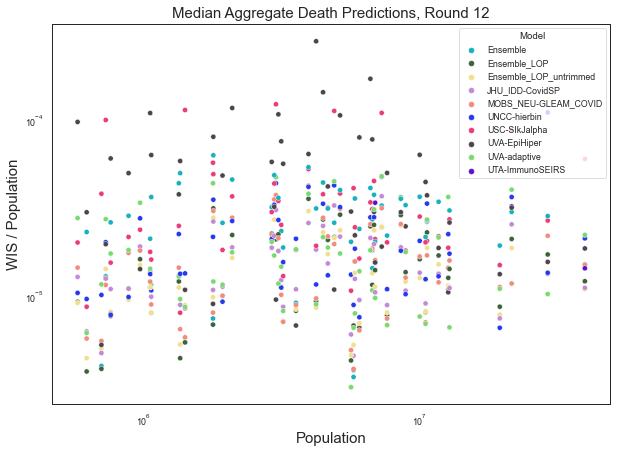

In [162]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_palette(flatui)
sns.scatterplot(ax = ax, data=df_all_hosp, x=df_all_death['Population'],
                y=df_all_death['WIS']/df_all_death['Population'],
                hue='Model', s=27 ).set(title='Median Aggregate Death Predictions, Round 12')
ax.set( ylabel='WIS / Population')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('wispop_death.pdf')
plt.show()

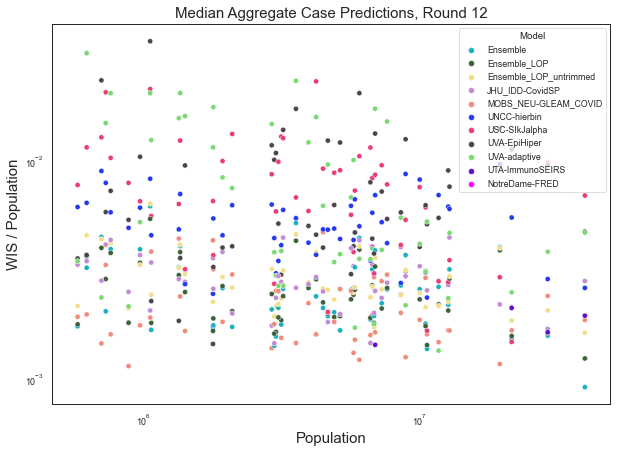

In [163]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9',
         'magenta', 'coral']
sns.set_palette(flatui)

#sns.set_style("white")
#sns.axes_style("white")
#sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_palette(flatui)
sns.scatterplot(ax = ax, data=df_all_case, x=df_all_case['Population'],
                y=df_all_case['WIS']/df_all_case['Population'],
                hue='Model', s=27).set(title='Median Aggregate Case Predictions, Round 12')

ax.set( ylabel='WIS / Population')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('wispop_case.pdf')
plt.show()

In [164]:
from scipy.stats import linregress

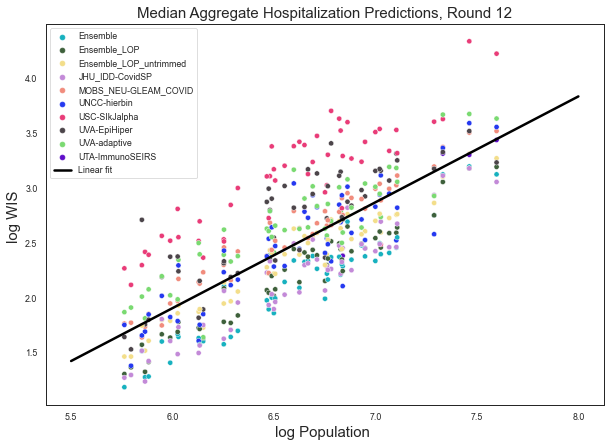

In [166]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_all_hosp,x=np.log10(df_all_hosp['Population'].astype('float64')),
                y=np.log10(df_all_hosp['WIS'])
                , hue='Model' , s=27).set(title='Median Aggregate Hospitalization Predictions, Round 12')

slope, intercept, r_value, p_value, std_err = linregress(np.log10(df_all_hosp['Population'].astype('float64')),
                                                         np.log10(df_all_hosp['WIS']))

xfid = np.linspace(5.5, 8)     # This is just a set of x to plot the straight line 

plt.plot(xfid, xfid*slope+intercept,'k',label='Linear fit',lw=2.5)


plt.legend()
ax.set( ylabel='log WIS ')
ax.set( xlabel='log Population ')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_hosp_unnormalized_linfit.pdf')
plt.show()

In [812]:
slope

0.9712244647055152

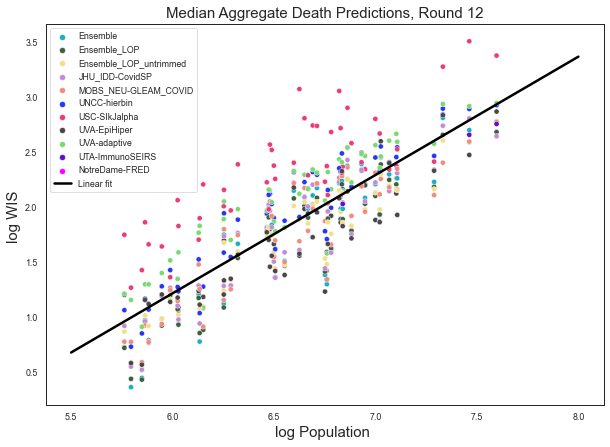

In [168]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9', 'magenta']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_palette(flatui)
sns.scatterplot(ax = ax, data=df_all_death, x=np.log10(df_all_death['Population'].astype('float64')),
                y=np.log10(df_all_death['WIS']),
                hue='Model', s=27 ).set(title='Median Aggregate Death Predictions, Round 12')

#b, a = np.polyfit(np.log10(df_all_death['Population'].astype('float64')), np.log10(df_all_death['WIS']), deg=1)

# Create sequence of 100 numbers from 0 to 100 
#xseq = np.linspace(500000, 50000000, num=100)

# Plot regression line
#ax.plot(np.log10(xseq), a + b * np.log10(xseq), color="k", lw=2.5, label='Linear fit');


slope, intercept, r_value, p_value, std_err = linregress(np.log10(df_all_death['Population'].astype('float64')),
                                                         np.log10(df_all_death['WIS']))

xfid = np.linspace(5.5, 8)     # This is just a set of x to plot the straight line 

plt.plot(xfid, xfid*slope+intercept,'k',label='Linear fit',lw=2.5)


plt.legend()
ax.set( ylabel='log WIS ')
ax.set( xlabel='log Population ')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_death_unnormalized_linfit.pdf')
plt.show()

In [810]:
slope

1.1010280676678506

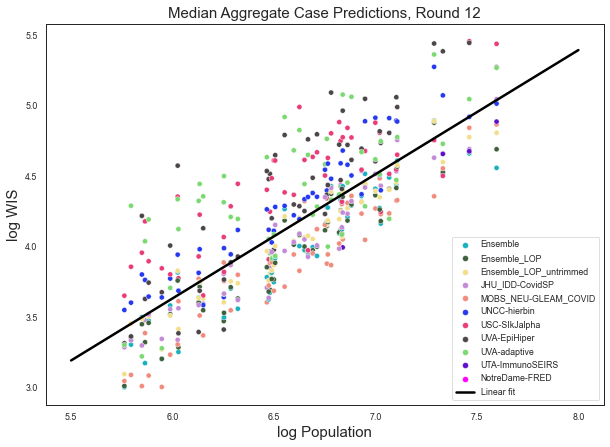

In [170]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9',
         'magenta', 'coral']
sns.set_palette(flatui)

#sns.set_style("white")
#sns.axes_style("white")
#sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
#sns.set_palette(flatui)
sns.scatterplot(ax = ax, data=df_all_case, x=np.log10(df_all_case['Population'].astype('float64')),
                y=np.log10(df_all_case['WIS']),
                hue='Model', s=27).set(title='Median Aggregate Case Predictions, Round 12')


slope, intercept, r_value, p_value, std_err = linregress(np.log10(df_all_case['Population'].astype('float64')),
                                                         np.log10(df_all_case['WIS']))

xfid = np.linspace(5.5, 8)     # This is just a set of x to plot the straight line 

plt.plot(xfid, xfid*slope+intercept,'k',label='Linear fit',lw=2.5)



plt.legend()
ax.set( ylabel='log WIS')
ax.set( xlabel='log Population')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_case_unnormalized_linfit.pdf')
plt.show()

In [808]:
slope

0.8823631599324231

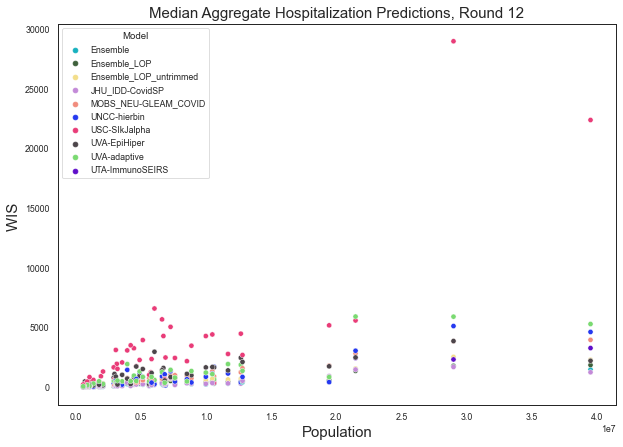

In [625]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_all_hosp,x=df_all_hosp['Population'],
                y=df_all_hosp['WIS']
                , hue='Model' , s=27).set(title='Median Aggregate Hospitalization Predictions, Round 12')
ax.set( ylabel='WIS ')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_hosp_unnormalized_linlin.pdf')
plt.show()

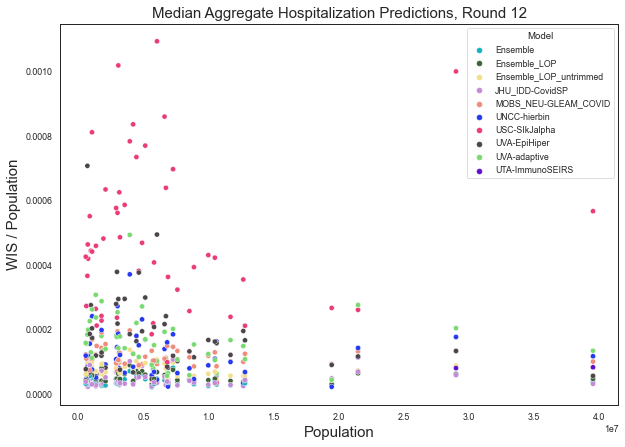

In [627]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_all_hosp,x=df_all_hosp['Population'],
                y=df_all_hosp['WIS']/df_all_hosp['Population']
                , hue='Model' , s=27).set(title='Median Aggregate Hospitalization Predictions, Round 12')
ax.set( ylabel='WIS / Population')
#plt.xscale('log')
#plt.yscale('log')
plt.savefig('wispop_hosp_linlin.pdf')
plt.show()

# Ranking Distributions

In [175]:
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","UNCC-hierbin","USC-SIkJalpha",
           "UVA-EpiHiper","UVA-adaptive"]

dfrank = pd.DataFrame(columns=['Model', 'Location', 'Rank'])

states = list(df_all_hosp.Location.unique())
target = 'death'

if target == 'hosp':
    df = df_all_hosp
elif target == 'death':
    df = df_all_death
elif target == 'case':
    df = df_all_case
    
    
for state in states:
    filt = df[df['Location']==state]
    filt = filt.sort_values('WIS')

    rank = list(filt.Model)
    for model in models:
        if model not in rank:
            continue
        rankval = rank.index(model)+1
        
        new_row = {'Model':model, 'Location': state, 'Rank': rankval}
 
        dfrank = dfrank.append(new_row, ignore_index=True)

In [176]:
dfrank_death = dfrank

In [489]:
dfrank_case.head(10)

,Model,Location,Rank
0,Ensemble,Alabama,3
1,Ensemble_LOP,Alabama,2
2,Ensemble_LOP_untrimmed,Alabama,5
3,JHU_IDD-CovidSP,Alabama,4
4,MOBS_NEU-GLEAM_COVID,Alabama,1
5,UNCC-hierbin,Alabama,7
6,USC-SIkJalpha,Alabama,9
7,UVA-EpiHiper,Alabama,8
8,UVA-adaptive,Alabama,6
9,Ensemble,Alaska,1


In [330]:
dfrank_death.head(10)

,Model,Location,Rank
0,Ensemble,Alabama,5
1,Ensemble_LOP,Alabama,3
2,Ensemble_LOP_untrimmed,Alabama,2
3,JHU_IDD-CovidSP,Alabama,6
4,MOBS_NEU-GLEAM_COVID,Alabama,4
5,UNCC-hierbin,Alabama,7
6,USC-SIkJalpha,Alabama,9
7,UVA-EpiHiper,Alabama,1
8,UVA-adaptive,Alabama,8
9,Ensemble,Alaska,4


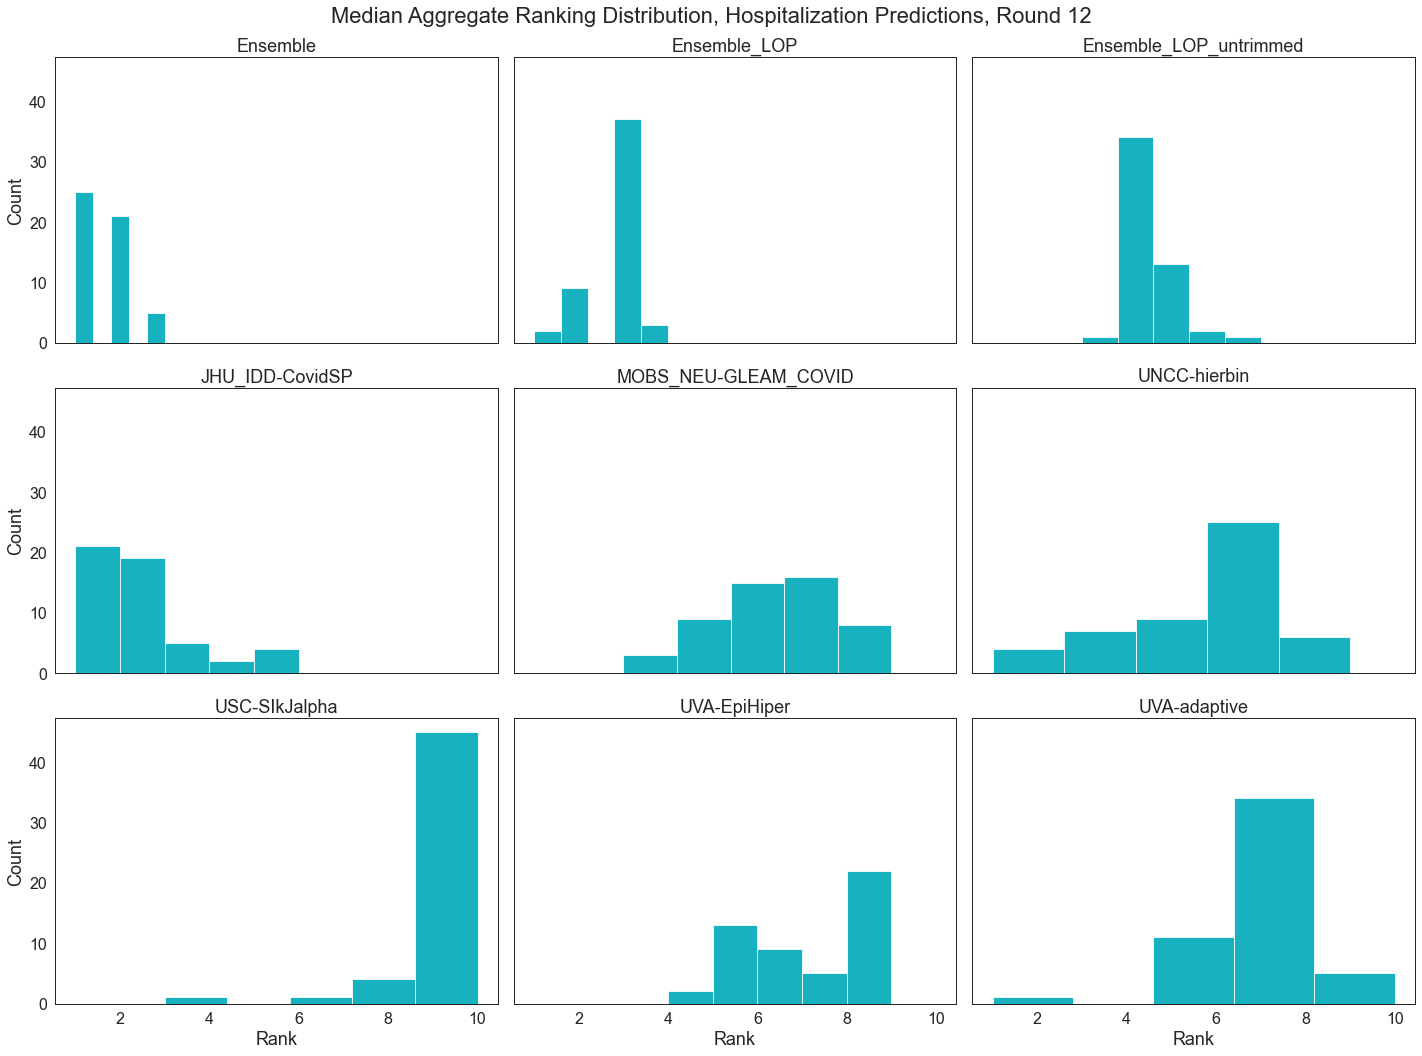

In [613]:

plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_hosp.plot.hist( column='Rank', by='Model', bins=5, grid=False, figsize=(20,15), layout=(3,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, Hospitalization Predictions, Round 12", fontsize=22)
plt.tight_layout()
#plt.savefig('hosp_rd12_rankings.pdf')
plt.show()

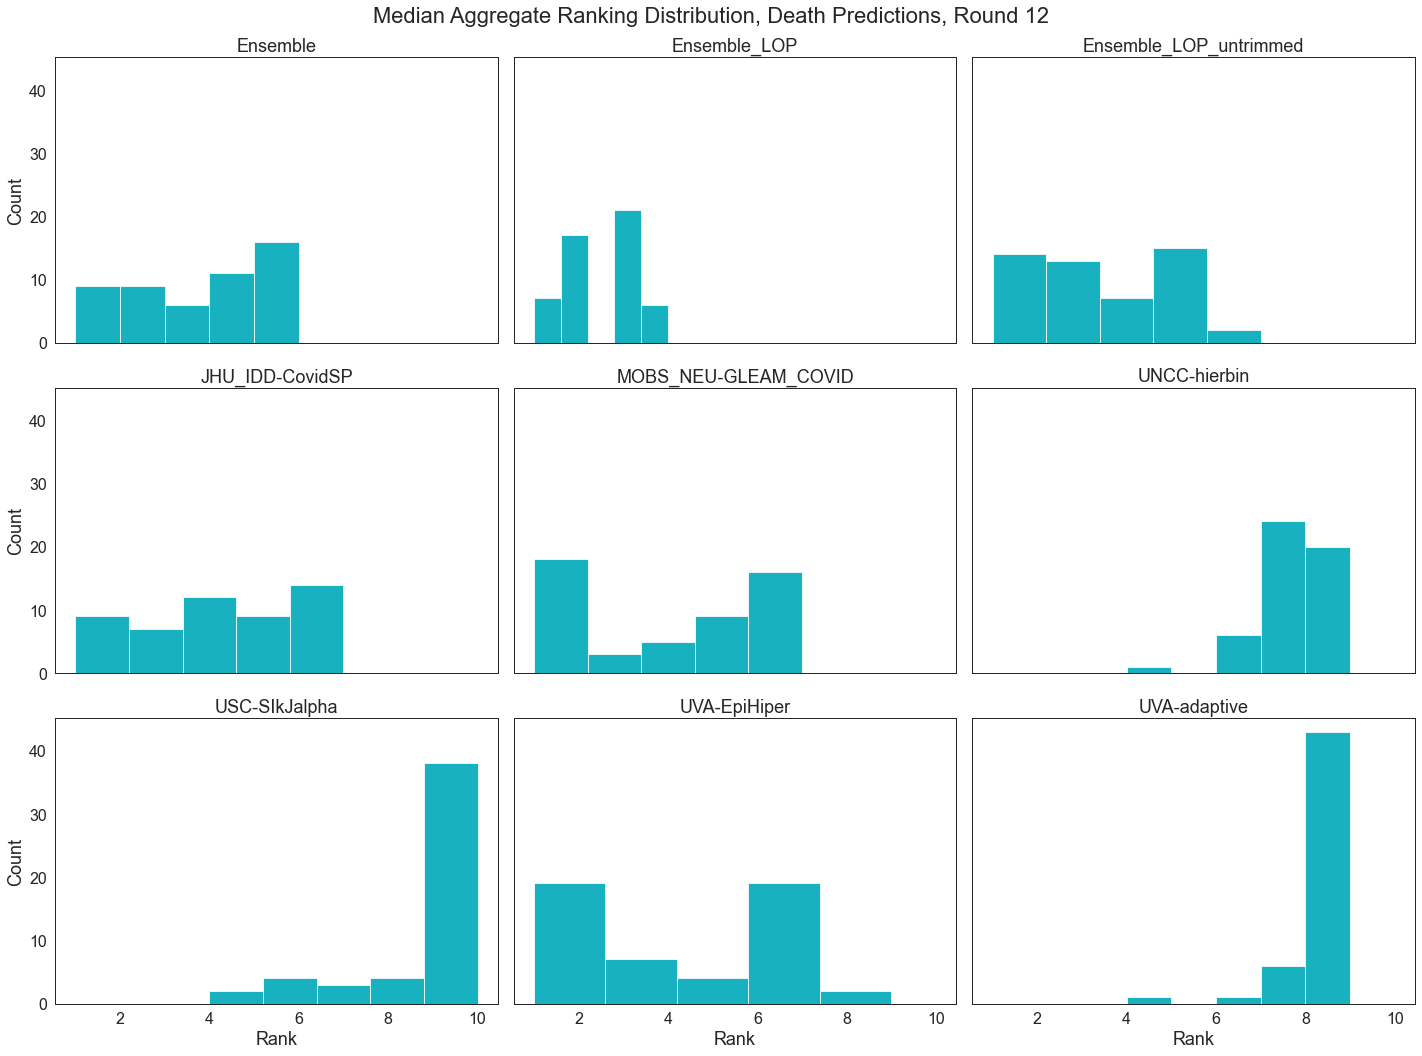

In [603]:
plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_death.plot.hist( column='Rank', by='Model', bins=5, grid=False, figsize=(20,15), layout=(3,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, Death Predictions, Round 12", fontsize=22)
plt.tight_layout()
#plt.savefig('death_rd12_rankings.pdf')
plt.show()

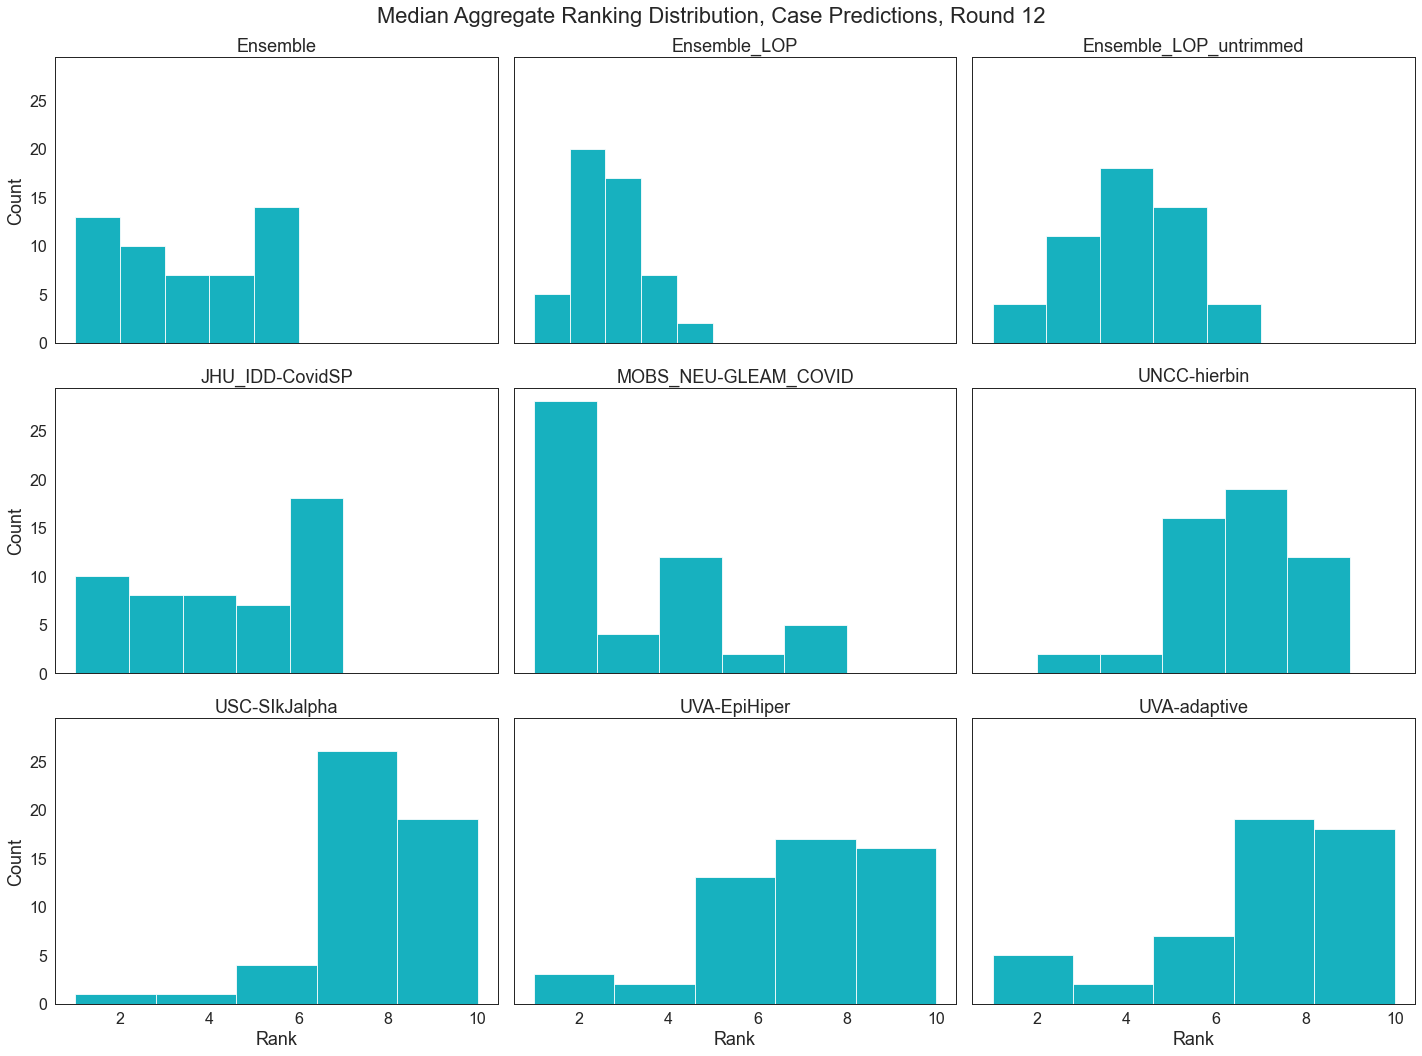

In [606]:
plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_case.plot.hist( column='Rank', by='Model', bins=5, grid=False, figsize=(20,15), layout=(3,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, Case Predictions, Round 12", fontsize=22)
plt.tight_layout()
#plt.savefig('case_rd12_rankings.pdf')
plt.show()

In [177]:
dfrank_all = pd.concat([dfrank_hosp, dfrank_case, dfrank_death])
dfrank_all = dfrank_all.reset_index()

In [597]:
dfrank_all

,index,Model,Location,Rank
0,0,Ensemble,Alabama,2
1,1,Ensemble_LOP,Alabama,3
2,2,Ensemble_LOP_untrimmed,Alabama,4
3,3,JHU_IDD-CovidSP,Alabama,5
4,4,MOBS_NEU-GLEAM_COVID,Alabama,1
...,...,...,...,...
1372,454,MOBS_NEU-GLEAM_COVID,Wyoming,1
1373,455,UNCC-hierbin,Wyoming,6
1374,456,USC-SIkJalpha,Wyoming,9
1375,457,UVA-EpiHiper,Wyoming,8


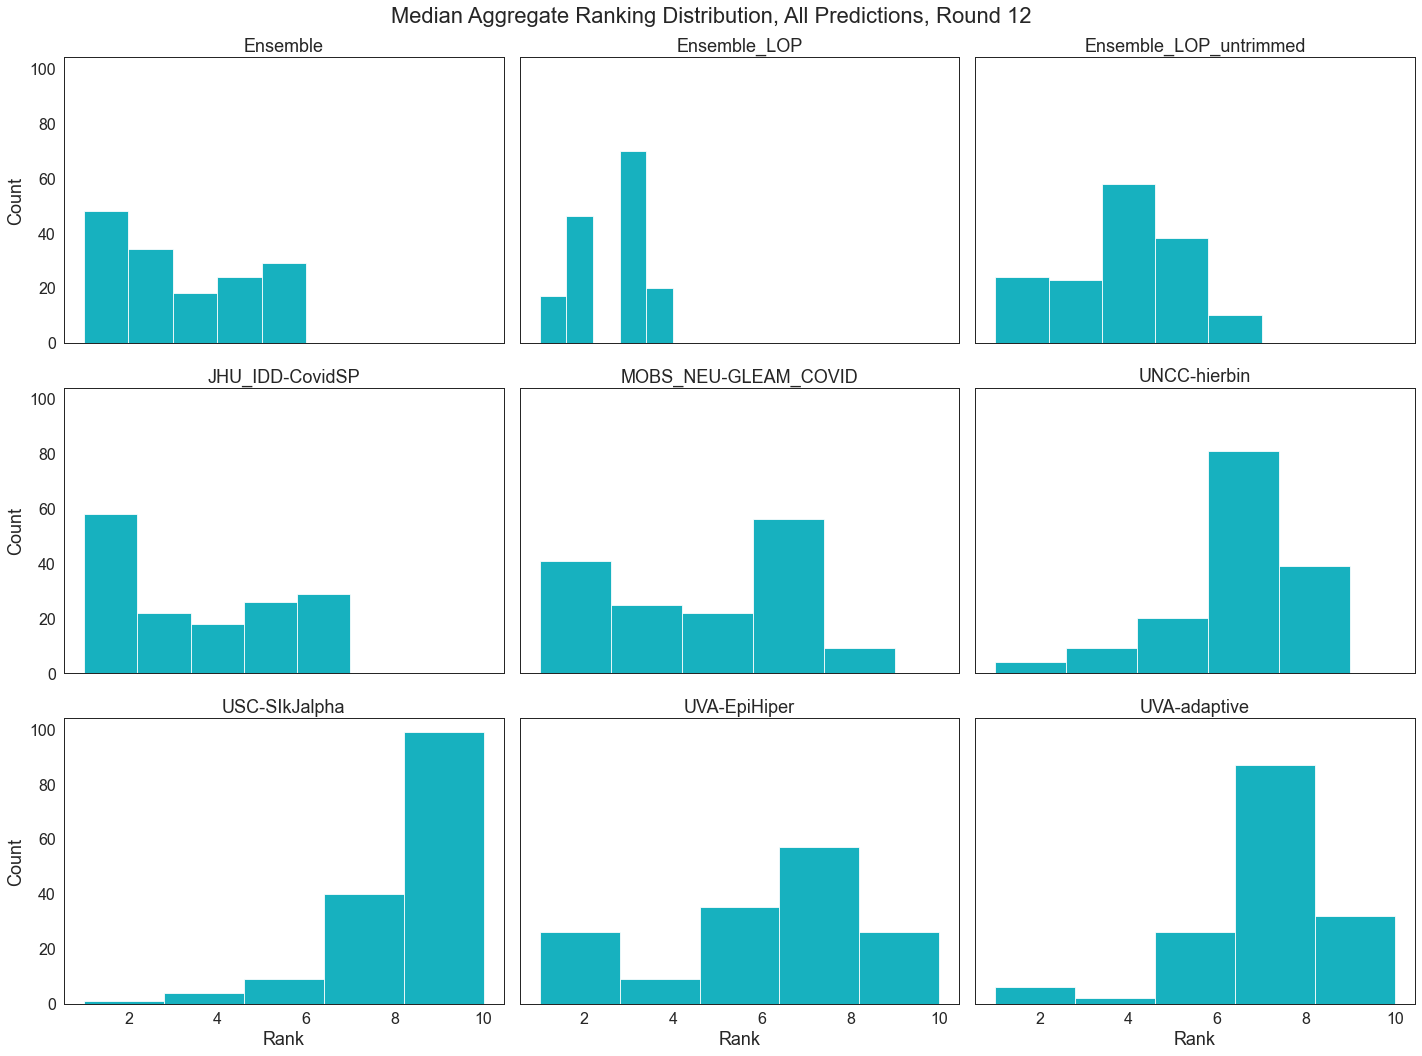

In [178]:
plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_all.plot.hist( column='Rank', by='Model', bins=5, grid=False, figsize=(20,15), layout=(3,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=16, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=18)
    a.set_ylabel("Count", fontsize=18)
    
plt.suptitle("Median Aggregate Ranking Distribution, All Predictions, Round 12", fontsize=22)
plt.tight_layout()
#plt.savefig('all_rd12_rankings.pdf')
plt.show()

In [558]:
dftab = df_all_hosp[df_all_hosp['Location']=='Massachusetts']
dftab = dftab.drop(['Location', 'Population'], axis=1).reset_index()
dftab = dftab.drop(['index'], axis=1)

dftab.style.set_caption("Round 12 Hospitalizations, location = MA")

,Model,WIS,50% Coverage,95% Coverage
0,Ensemble,230.333895,0.333333,0.666667
1,Ensemble_LOP,214.235047,1.000000,1.000000
2,Ensemble_LOP_untrimmed,278.319468,1.000000,1.000000
3,JHU_IDD-CovidSP,429.109955,0.000000,0.444444
4,MOBS_NEU-GLEAM_COVID,411.623121,0.333333,0.666667
5,UNCC-hierbin,182.804204,0.555556,0.666667
6,USC-SIkJalpha,1882.408106,0.111111,0.111111
7,UTA-ImmunoSEIRS,396.106762,0.000000,0.222222
8,UVA-EpiHiper,795.905103,0.222222,0.666667
9,UVA-adaptive,393.542616,0.222222,0.555556


In [525]:
dftab.columns

Index(['Model', 'WIS', '50% Coverage', '95% Coverage', 'Location',
       'Population'],
      dtype='object')

In [86]:
model = "MOBS_NEU-GLEAM_COVID"
rd=12
predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')

loclist = ['US']

rd = 12
start_week = Week(2022,2)
end_week = Week(2022,13)
#max_date = datetime.datetime(2022, 3, 15)
max_date = None
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","NotreDame-FRED","UNCC-hierbin","USC-SIkJalpha",
           "UTA-ImmunoSEIRS","UVA-EpiHiper","UVA-adaptive"]


median_ensembles = dict()
extreme_ensembles = dict()

df = pd.DataFrame(columns=['Model', 'WIS','50% Coverage','95% Coverage', 'Location', 'Population'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    #target = 'death'
    target = 'hosp'
    #target = 'case'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    


    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location == 'US']
            #predictions = predictions.astype({'location':'int'})
            
            
            #locations = locations[locations.location != 'US']
            #locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = target_location
            
            pred = predictions[predictions['location'] == 'US'].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            
            
            labels = ["Median aggregate"]


            aggregated_scores = dict()
            for label,predictions in zip(labels,predictions_list):
                d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
                aggregated_scores[label] = d

            aggregated_data = defaultdict(list)
            for label in labels:
                aggregated_data['Case'] += [label]
                aggregated_data['WIS'] += [aggregated_scores[label]['wis_mean']]
                aggregated_data['Cov50'] += [aggregated_scores[label]['50_cov']]
                aggregated_data['Cov95'] += [aggregated_scores[label]['95_cov']]

            agg_data_df = pd.DataFrame(aggregated_data)
            agg_data_df['Model'] = model
            wisval = agg_data_df.WIS[0]
            cov50val = agg_data_df.Cov50[0]
            cov95val = agg_data_df.Cov95[0]

            
            locname = list(pred.location_name.unique())[0]
            popsize = list(pred.population.unique())[0]


            new_row = {'Model':model, 'WIS':wisval,'50% Coverage':cov50val, '95% Coverage':cov95val,
                       'Location': locname, 'Population': popsize}
 
            df = df.append(new_row, ignore_index=True)
                    
        except Exception as e:
            print(e)    
    


There are no predictions for model NCSU-COVSIM at location US
There are no predictions for model NotreDame-FRED at location US
There are no predictions for model UTA-ImmunoSEIRS at location US


In [136]:
list(med_ensemble_predictions.target_end_date.unique())

[numpy.datetime64('2022-01-15T00:00:00.000000000'),
 numpy.datetime64('2022-01-22T00:00:00.000000000'),
 numpy.datetime64('2022-01-29T00:00:00.000000000'),
 numpy.datetime64('2022-02-05T00:00:00.000000000'),
 numpy.datetime64('2022-02-12T00:00:00.000000000'),
 numpy.datetime64('2022-02-19T00:00:00.000000000'),
 numpy.datetime64('2022-02-26T00:00:00.000000000'),
 numpy.datetime64('2022-03-05T00:00:00.000000000'),
 numpy.datetime64('2022-03-12T00:00:00.000000000')]

In [87]:
median_ensembles_us_hosp = median_ensembles
extreme_ensembles_us_hosp = extreme_ensembles

df_us_hosp = df

In [88]:
dftab = df_us_hosp.drop(['Location', 'Population'], axis=1).reset_index()
dftab = dftab.drop(['index'], axis=1)

dftab.style.set_caption("Round 12 Hospitalization, location = US")

,Model,WIS,50% Coverage,95% Coverage
0,Ensemble,13066.221771,0.333333,0.666667
1,Ensemble_LOP,16361.426119,1.000000,1.000000
2,Ensemble_LOP_untrimmed,22139.663518,1.000000,1.000000
3,JHU_IDD-CovidSP,19176.009223,0.000000,0.222222
4,MOBS_NEU-GLEAM_COVID,21376.951609,0.444444,0.777778
5,UNCC-hierbin,42247.407322,0.000000,0.111111
6,USC-SIkJalpha,98228.447749,0.111111,0.111111
7,UVA-EpiHiper,131385.464947,0.000000,0.000000
8,UVA-adaptive,29267.093478,0.111111,0.333333


In [90]:
print(dftab.round(2).to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                 Model &       WIS &  50\% Coverage &  95\% Coverage \\
\midrule
              Ensemble &  13066.22 &          0.33 &          0.67 \\
          Ensemble\_LOP &  16361.43 &          1.00 &          1.00 \\
Ensemble\_LOP\_untrimmed &  22139.66 &          1.00 &          1.00 \\
       JHU\_IDD-CovidSP &  19176.01 &          0.00 &          0.22 \\
  MOBS\_NEU-GLEAM\_COVID &  21376.95 &          0.44 &          0.78 \\
          UNCC-hierbin &  42247.41 &          0.00 &          0.11 \\
         USC-SIkJalpha &  98228.45 &          0.11 &          0.11 \\
          UVA-EpiHiper & 131385.46 &          0.00 &          0.00 \\
          UVA-adaptive &  29267.09 &          0.11 &          0.33 \\
\bottomrule
\end{tabular}



# Coverage table averaged over locations

In [629]:
df_all_hosp.Model.unique()


array(['Ensemble', 'Ensemble_LOP', 'Ensemble_LOP_untrimmed',
       'JHU_IDD-CovidSP', 'MOBS_NEU-GLEAM_COVID', 'UNCC-hierbin',
       'USC-SIkJalpha', 'UVA-EpiHiper', 'UVA-adaptive', 'UTA-ImmunoSEIRS'],
      dtype=object)

In [632]:
testdf = df_all_hosp.copy()

In [646]:
avgscoresdf = pd.DataFrame(columns=['Model', 'Average WIS','Average 50% Coverage','Average 95% Coverage'])

testdf = testdf[testdf.Model == 'Ensemble']
#testdf['normWIS'] = testdf['WIS']/testdf['Population']
avgWIS = testdf.WIS.mean()
avgcov50 = testdf['50% Coverage'].mean()
avgcov95 = testdf['95% Coverage'].mean()

new_row = {'Model':'ensemble', 'Average WIS':avgWIS,'Average 50% Coverage':avgcov50,'Average 95% Coverage':avgcov95 }

avgscoresdf = avgscoresdf.append(new_row, ignore_index=True)

/var/folders/1k/msfckb6d40q9g5y9b70y58hr0000gn/T/ipykernel_45125/2045713969.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  avgscoresdf = avgscoresdf.append(new_row, ignore_index=True)


In [229]:
df = df_wisnorm_case.copy()
#models = list(df.Model.unique())
models = ['Ensemble','Ensemble_LOP','Ensemble_LOP_untrimmed','JHU_IDD-CovidSP','MOBS_NEU-GLEAM_COVID','UNCC-hierbin',
 'USC-SIkJalpha','UVA-EpiHiper','UVA-adaptive']
avgscoresdf = pd.DataFrame(columns=['Model', 'Average WIS','Average 50% Coverage','Average 95% Coverage'])


for model in models:
    
    testdf = df[df.Model == model]
    #testdf['normWIS'] = testdf['WIS']/testdf['Population']
    avgWIS = testdf.WIS.mean()
    avgcov50 = testdf['50% Coverage'].mean()
    avgcov95 = testdf['95% Coverage'].mean()

    
    new_row = {'Model':model, 'Average WIS':avgWIS,'Average 50% Coverage':avgcov50,'Average 95% Coverage':avgcov95 }

    avgscoresdf = avgscoresdf.append(new_row, ignore_index=True)
    

In [230]:
avgscoresdf.style.set_caption("Round 12 Cases, average scores over all locations")

,Model,Average WIS,Average 50% Coverage,Average 95% Coverage
0,Ensemble,0.775212,0.361111,0.722222
1,Ensemble_LOP,0.797032,0.643791,0.983660
2,Ensemble_LOP_untrimmed,1.033874,0.776144,0.996732
3,JHU_IDD-CovidSP,0.743776,0.563725,0.986928
4,MOBS_NEU-GLEAM_COVID,0.698160,0.163399,0.400327
5,UNCC-hierbin,3.298612,0.029412,0.084967
6,USC-SIkJalpha,1.713923,0.133987,0.352941
7,UVA-EpiHiper,6.804036,0.086601,0.202614
8,UVA-adaptive,1.416847,0.147059,0.403595


In [231]:
print(avgscoresdf.round(2).to_latex(index=False))

\begin{tabular}{lrrr}
\toprule
                 Model &  Average WIS &  Average 50\% Coverage &  Average 95\% Coverage \\
\midrule
              Ensemble &         0.78 &                  0.36 &                  0.72 \\
          Ensemble\_LOP &         0.80 &                  0.64 &                  0.98 \\
Ensemble\_LOP\_untrimmed &         1.03 &                  0.78 &                  1.00 \\
       JHU\_IDD-CovidSP &         0.74 &                  0.56 &                  0.99 \\
  MOBS\_NEU-GLEAM\_COVID &         0.70 &                  0.16 &                  0.40 \\
          UNCC-hierbin &         3.30 &                  0.03 &                  0.08 \\
         USC-SIkJalpha &         1.71 &                  0.13 &                  0.35 \\
          UVA-EpiHiper &         6.80 &                  0.09 &                  0.20 \\
          UVA-adaptive &         1.42 &                  0.15 &                  0.40 \\
\bottomrule
\end{tabular}



# Coverage plot

In [184]:
median_ensembles = dict()
extreme_ensembles = dict()

coveragedf = pd.DataFrame(columns=['Model', '10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov',
                         '80_cov', '90_cov', '95_cov', '98_cov', 'Location', 'Case'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    target = 'death'
    #target = 'hosp'
    #target = 'case'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    

    
    

    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location != 'US']
            predictions = predictions.astype({'location':'int'})
            
            
            locations = locations[locations.location != 'US']
            locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = int(target_location)
            
            pred = predictions[predictions['location'] == int(target_location)].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
            
            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Median aggregate", "Extreme Aggregate"]

        


            aggregated_scores = dict()
            for label,predictions in zip(labels,predictions_list):
                d,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
                aggregated_scores[label] = d

            aggregated_data = defaultdict(list)
            
            coverages = ['10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov',
                         '80_cov', '90_cov', '95_cov', '98_cov']
            for label in ["Median aggregate"]:
                aggregated_data['Case'] += [label]
                
                for cv in coverages:
                
                    aggregated_data[cv] += [aggregated_scores[label][cv]]
                
                agg_data_df = pd.DataFrame(aggregated_data)
                agg_data_df['Model'] = model
                agg_data_df['Location'] = l
                

            
            
            
            
            
            coveragedf = pd.concat([coveragedf, agg_data_df])
            
            
  
        except Exception as e:
            print(e)    
    


There are no predictions for model NCSU-COVSIM at location 01
There are no predictions for model NCSU-COVSIM at location 02
There are no predictions for model NCSU-COVSIM at location 04
There are no predictions for model NCSU-COVSIM at location 05
There are no predictions for model NCSU-COVSIM at location 06
There are no predictions for model NCSU-COVSIM at location 08
There are no predictions for model NCSU-COVSIM at location 09
There are no predictions for model NCSU-COVSIM at location 10
There are no predictions for model NCSU-COVSIM at location 11
There are no predictions for model NCSU-COVSIM at location 12
There are no predictions for model NCSU-COVSIM at location 13
There are no predictions for model NCSU-COVSIM at location 15
There are no predictions for model NCSU-COVSIM at location 16
There are no predictions for model NCSU-COVSIM at location 17
There are no predictions for model NCSU-COVSIM at location 18
There are no predictions for model NCSU-COVSIM at location 19
There ar

In [181]:
coverages = ['10_cov', '20_cov', '30_cov', '40_cov', '50_cov', '60_cov', '70_cov', '80_cov', '90_cov', '95_cov', '98_cov']

In [185]:
coveragedf_death = coveragedf

In [186]:
coveragedf_hosp

,Model,10_cov,20_cov,30_cov,40_cov,50_cov,60_cov,70_cov,80_cov,90_cov,95_cov,98_cov,Location,Case
0,Ensemble,0.000000,0.000000,0.000000,0.166667,0.166667,0.333333,0.416667,0.666667,0.666667,1.000000,1.000000,01,Median aggregate
0,Ensemble_LOP,0.000000,0.000000,0.166667,0.333333,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,01,Median aggregate
0,Ensemble_LOP_untrimmed,0.000000,0.166667,0.500000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,01,Median aggregate
0,JHU_IDD-CovidSP,0.000000,0.000000,0.000000,0.083333,0.083333,0.083333,0.166667,0.500000,1.000000,1.000000,1.000000,01,Median aggregate
0,MOBS_NEU-GLEAM_COVID,0.083333,0.166667,0.166667,0.166667,0.166667,0.250000,0.250000,0.416667,0.416667,0.416667,0.500000,01,Median aggregate
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,MOBS_NEU-GLEAM_COVID,0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.250000,0.333333,0.583333,0.583333,0.750000,56,Median aggregate
0,UNCC-hierbin,0.000000,0.000000,0.083333,0.083333,0.083333,0.083333,0.083333,0.083333,0.166667,0.250000,0.250000,56,Median aggregate
0,USC-SIkJalpha,0.083333,0.166667,0.166667,0.166667,0.166667,0.250000,0.250000,0.333333,0.416667,0.416667,0.500000,56,Median aggregate
0,UVA-EpiHiper,0.000000,0.000000,0.083333,0.166667,0.166667,0.166667,0.166667,0.250000,0.416667,0.416667,0.583333,56,Median aggregate


In [196]:
#df = pd.concat([coveragedf_death, coveragedf_case, coveragedf_hosp])
df = coveragedf_hosp.copy()
#models = list(df.Model.unique())
models = ['Ensemble','Ensemble_LOP','Ensemble_LOP_untrimmed','JHU_IDD-CovidSP','MOBS_NEU-GLEAM_COVID','UNCC-hierbin',
 'USC-SIkJalpha','UVA-EpiHiper','UVA-adaptive']
#models = models[0:-2]

avgcov = {}

for model in models:
    testdf = df[df.Model == model]
    avgcov[model] = []
    
    for cv in coverages:
        cov = testdf[cv].mean()
        avgcov[model].append(cov)

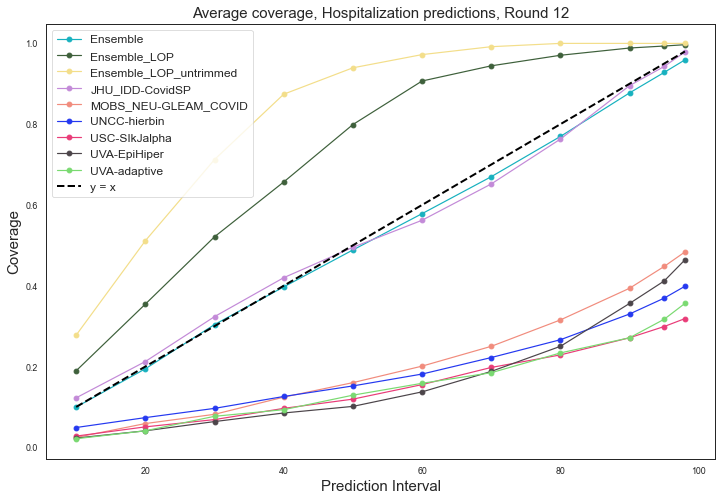

In [198]:
plt.figure(figsize=(12,8))

covers = [10,20,30,40,50,60,70,80,90,95,98]
covsy = [cv/100 for cv in covers]

for model in models:
    plt.plot(covers, avgcov[model],'-o', label=model)
    
plt.plot(covers, covsy, 'k--',label = 'y = x',linewidth=2)  

plt.xlabel('Prediction Interval', fontsize=15)
plt.ylabel('Coverage', fontsize=15)
plt.title('Average coverage, Hospitalization predictions, Round 12', fontsize=15)
plt.legend(fontsize=12)
plt.savefig('coverage_interval_hosp_rd12.pdf')
plt.show()


In [109]:
list(df.Model.unique())

['Ensemble',
 'Ensemble_LOP',
 'Ensemble_LOP_untrimmed',
 'JHU_IDD-CovidSP',
 'MOBS_NEU-GLEAM_COVID',
 'UNCC-hierbin',
 'USC-SIkJalpha',
 'UVA-EpiHiper',
 'UVA-adaptive',
 'UTA-ImmunoSEIRS',
 'NotreDame-FRED']

In [733]:
list(np.linspace(0,1,len(covers)))

[0.0,
 0.1,
 0.2,
 0.30000000000000004,
 0.4,
 0.5,
 0.6000000000000001,
 0.7000000000000001,
 0.8,
 0.9,
 1.0]

# Normalize WIS by observations

In [212]:
median_ensembles = dict()
extreme_ensembles = dict()

df = pd.DataFrame(columns=['Model', 'WIS','50% Coverage', '95% Coverage', 'Location', 'Population','Label'])

for l in loclist:
    median_ensembles[l] = {}
    extreme_ensembles[l] = {}
    
    target = 'death'
    #target = 'hosp'
    #target = 'case'
    incidence = True
    target_location = l
    
    
    if target == 'hosp':
        target_obs = 'hospitalization'
    else:
        target_obs = target
    observations = pd.read_parquet(f"./dat/truth_{'inc' if incidence else 'cum'}_{target_obs}.pq")
    observations['date'] = pd.to_datetime(observations['date'])

    #filter start - end week
    observations = observations[(observations['date'] >= pd.to_datetime(start_week.startdate())) & 
                            (observations['date'] <= pd.to_datetime(end_week.enddate()))]


    
    #filter location
    observations = observations[observations['location'] == target_location]

    #aggregate to weekly
    observations = observations.groupby(['location', pd.Grouper(key='date', freq='W-SAT')]).sum().reset_index()

    if max_date:
        observations = observations[observations['date'] <= max_date].copy()

    #transform to Observation object
    observations = Observations(observations)
    

    
    

    
    locations = pd.read_csv('./dat/locations.csv',dtype={'location':str})
    location_mapping = dict()
    for loc in locations['location']:
        location_mapping[loc] = locations[locations['location'] == loc]['abbreviation'].unique()[0]
    
    
    target_prediction_list = [f"{i} wk ahead {'inc' if incidence else 'cum'} {target}" for i in range(1,len(observations)+1)]
    
    for model in models:    
        try:
            predictions = pd.read_parquet(f'./dat/{model}_rd{rd}.pq')
            predictions['target_end_date'] = pd.to_datetime(predictions['target_end_date'])
            predictions = predictions[predictions.location != 'US']
            predictions = predictions.astype({'location':'int'})
            
            
            locations = locations[locations.location != 'US']
            locations = locations.astype({'location':'int'})
            
            predictions = predictions.merge(locations, how='inner', on='location')
            
            target_locations = int(target_location)
            
            pred = predictions[predictions['location'] == int(target_location)].copy()
        
            #filter target
            pred = pred[(pred['target'].isin(target_prediction_list))]
            
            #filter max date
            if max_date:
                pred = pred[pred['target_end_date'] <= max_date]

            if len(pred) == 0:
                raise RuntimeError(f"There are no predictions for model {model} at location {target_location}")

            scenarios = list(pred['scenario_id'].drop_duplicates())
            predictions_list = [Predictions(pred[pred['scenario_id'] == scenario], t_col='target_end_date') for scenario in scenarios]
            med_ensemble_predictions = median_ensemble(predictions_list)
            ex_ensemble_predictions = extreme_ensemble(predictions_list)
            median_ensembles[l][model] = med_ensemble_predictions
            extreme_ensembles[l][model] = ex_ensemble_predictions
            
            predictions_list += [med_ensemble_predictions, ex_ensemble_predictions]
            
            labels = ["Scenario " + scenario[0] for scenario in sorted(scenarios)] + ["Median aggregate", "Extreme Aggregate"]

        
            aggregated_scores = dict()
            aggscore_cov = dict()
            for label,predictions in zip(labels,predictions_list):
                dcov,_ = score_utils.all_scores_from_df(observations, predictions, mismatched_allowed=False)
                d = score_utils.all_timestamped_scores_from_df(observations, predictions)
                
                
                
                
                aggscore_cov[label] = dcov
                
                
                aggregated_scores[label] = d
            label = 'Median aggregate'
                
            medagg = aggregated_scores[label]
            
            wisvals = list(medagg.wis)
            obsvals = list(observations.value)
            
            wisnorm = []
            for ind in range(len(wisvals)):
                if obsvals[ind] == 0:
                    continue
                else:
                    wisnorm.append(wisvals[ind]/obsvals[ind])
        
        
            wisval = np.mean(wisnorm)
        
        
            
            aggregated_data = defaultdict(list)
            for label in ["Median aggregate"]:
                aggregated_data['Case'] += [label]
                aggregated_data['Cov50'] += [aggscore_cov[label]['50_cov']]
                aggregated_data['Cov95'] += [aggscore_cov[label]['95_cov']]

                agg_data_df = pd.DataFrame(aggregated_data)
                agg_data_df['Model'] = model
                cov50val = agg_data_df.Cov50[0]
                cov95val = agg_data_df.Cov95[0]
            
            
            
            
            locname = list(pred.location_name.unique())[0]
            popsize = list(pred.population.unique())[0]


            new_row = {'Model':model, 'WIS':wisval, '50% Coverage':cov50val, '95% Coverage':cov95val,
                       'Location': locname, 'Population': popsize, 'Label':label}
 
            df = df.append(new_row, ignore_index=True)
            
            
        except Exception as e:
            print(e)    
    


There are no predictions for model NCSU-COVSIM at location 01
There are no predictions for model NotreDame-FRED at location 01
There are no predictions for model UTA-ImmunoSEIRS at location 01
There are no predictions for model NCSU-COVSIM at location 02
There are no predictions for model NotreDame-FRED at location 02
There are no predictions for model UTA-ImmunoSEIRS at location 02
There are no predictions for model NCSU-COVSIM at location 04
There are no predictions for model NotreDame-FRED at location 04
There are no predictions for model UTA-ImmunoSEIRS at location 04
There are no predictions for model NCSU-COVSIM at location 05
There are no predictions for model NotreDame-FRED at location 05
There are no predictions for model UTA-ImmunoSEIRS at location 05
There are no predictions for model NCSU-COVSIM at location 06
There are no predictions for model NotreDame-FRED at location 06
There are no predictions for model NCSU-COVSIM at location 08
There are no predictions for model Notr

There are no predictions for model UTA-ImmunoSEIRS at location 49
There are no predictions for model NCSU-COVSIM at location 50
There are no predictions for model NotreDame-FRED at location 50
There are no predictions for model UTA-ImmunoSEIRS at location 50
There are no predictions for model NCSU-COVSIM at location 51
There are no predictions for model NotreDame-FRED at location 51
There are no predictions for model UTA-ImmunoSEIRS at location 51
There are no predictions for model NCSU-COVSIM at location 53
There are no predictions for model NotreDame-FRED at location 53
There are no predictions for model UTA-ImmunoSEIRS at location 53
There are no predictions for model NCSU-COVSIM at location 54
There are no predictions for model NotreDame-FRED at location 54
There are no predictions for model UTA-ImmunoSEIRS at location 54
There are no predictions for model NCSU-COVSIM at location 55
There are no predictions for model NotreDame-FRED at location 55
There are no predictions for model 

In [213]:
df_wisnorm_death = df
#df_wisnorm_hosp = df
#df_wisnorm_case = df

In [214]:
df_wisnorm_case

,Model,WIS,50% Coverage,95% Coverage,Location,Population,Label
0,Ensemble,0.460725,0.666667,0.916667,Alabama,4903185,Median aggregate
1,Ensemble_LOP,0.586710,0.916667,1.000000,Alabama,4903185,Median aggregate
2,Ensemble_LOP_untrimmed,0.833322,0.916667,1.000000,Alabama,4903185,Median aggregate
3,JHU_IDD-CovidSP,0.486177,0.833333,1.000000,Alabama,4903185,Median aggregate
4,MOBS_NEU-GLEAM_COVID,0.706110,0.250000,0.416667,Alabama,4903185,Median aggregate
...,...,...,...,...,...,...,...
459,MOBS_NEU-GLEAM_COVID,0.632624,0.166667,0.666667,Wyoming,578759,Median aggregate
460,UNCC-hierbin,9.142372,0.000000,0.083333,Wyoming,578759,Median aggregate
461,USC-SIkJalpha,1.067316,0.166667,0.583333,Wyoming,578759,Median aggregate
462,UVA-EpiHiper,4.515810,0.083333,0.166667,Wyoming,578759,Median aggregate


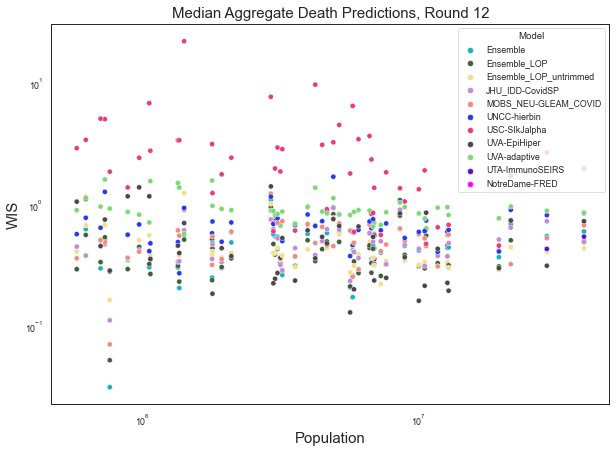

In [215]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9',
         'magenta']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)


sns.scatterplot(ax = ax, data = df_wisnorm_death,x=df_wisnorm_death['Population'],
                y=df_wisnorm_death['WIS']
                , hue='Model' , s=27).set(title='Median Aggregate Death Predictions, Round 12')
ax.set( ylabel='WIS')
plt.xscale('log')
plt.yscale('log')
#plt.savefig('wisnorm_pop_death.pdf')
plt.show()

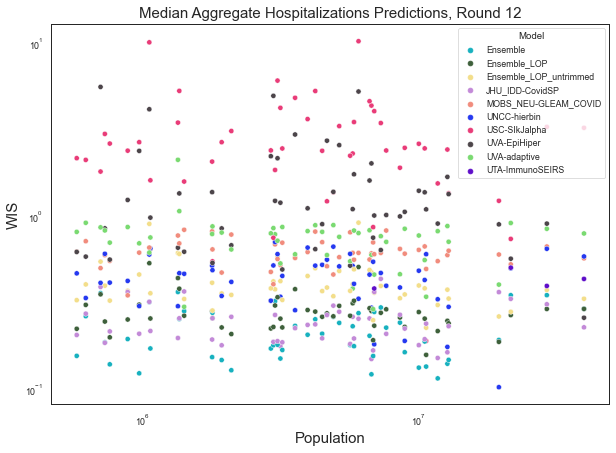

In [83]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9',
         'magenta']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_wisnorm_hosp,x=df_wisnorm_hosp['Population'],
                y=df_wisnorm_hosp['WIS']
                , hue='Model' , s=27).set(title='Median Aggregate Hospitalizations Predictions, Round 12')
ax.set( ylabel='WIS')
plt.xscale('log')
plt.yscale('log')
plt.savefig('wisnorm_pop_hosp.pdf')
plt.show()

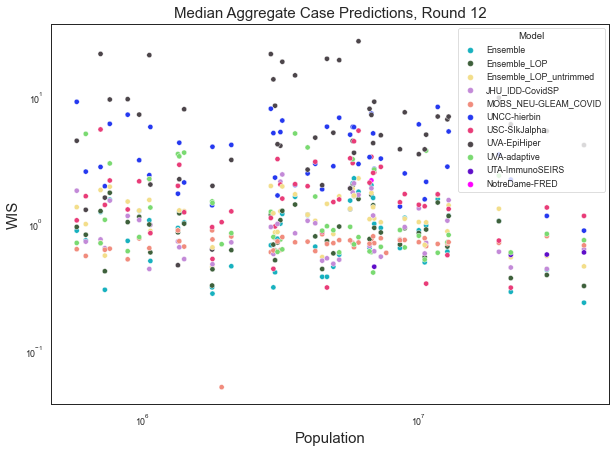

In [217]:
fig, ax = plt.subplots(figsize=(10,7))
flatui = ['#17B1BF', '#3E603B', '#F3DE8A', '#C38AD8', '#F18C7D', '#2539F0', '#E93C78', '#4C454A', '#7ADA71', '#5F0EC9',
         'magenta']
sns.set_palette(flatui)

sns.set_style("white")
sns.axes_style("white")
sns.set_context("paper", rc={"font.size":15,"axes.titlesize":15,"axes.labelsize":15})
sns.set_palette(flatui)




sns.scatterplot(ax = ax, data = df_wisnorm_case,x=df_wisnorm_case['Population'],
                y=df_wisnorm_case['WIS']
                , hue='Model' , s=27).set(title='Median Aggregate Case Predictions, Round 12')
ax.set( ylabel='WIS')
plt.xscale('log')
plt.yscale('log')
plt.savefig('wisnorm_pop_case.pdf')
plt.show()

,Model,WIS,Location,Population,Label
0,Ensemble,0.497774,Alabama,4903185,Median aggregate
1,Ensemble_LOP,0.496739,Alabama,4903185,Median aggregate
2,Ensemble_LOP_untrimmed,0.640499,Alabama,4903185,Median aggregate
3,JHU_IDD-CovidSP,0.488007,Alabama,4903185,Median aggregate
4,MOBS_NEU-GLEAM_COVID,0.608932,Alabama,4903185,Median aggregate
...,...,...,...,...,...
459,MOBS_NEU-GLEAM_COVID,0.531528,Wyoming,578759,Median aggregate
460,UNCC-hierbin,3.835004,Wyoming,578759,Median aggregate
461,USC-SIkJalpha,1.353351,Wyoming,578759,Median aggregate
462,UVA-EpiHiper,1.857096,Wyoming,578759,Median aggregate


In [222]:
models = ["Ensemble","Ensemble_LOP","Ensemble_LOP_untrimmed","JHU_IDD-CovidSP","MOBS_NEU-GLEAM_COVID","NCSU-COVSIM","UNCC-hierbin","USC-SIkJalpha",
           "UVA-EpiHiper","UVA-adaptive"]

dfrank = pd.DataFrame(columns=['Model', 'Location', 'Rank'])

states = list(df_wisnorm_death.Location.unique())
target = 'death'

if target == 'hosp':
    df = df_wisnorm_hosp
elif target == 'death':
    df = df_wisnorm_death
elif target == 'case':
    df = df_wisnorm_case
    
    
for state in states:
    filt = df[df['Location']==state]
    filt = filt.sort_values('WIS')

    rank = list(filt.Model)
    for model in models:
        if model not in rank:
            continue
        rankval = rank.index(model)+1
        
        new_row = {'Model':model, 'Location': state, 'Rank': rankval}
 
        dfrank = dfrank.append(new_row, ignore_index=True)

In [223]:
dfrank_wisnorm_death = dfrank
#dfrank_wisnorm_hosp = dfrank
#dfrank_wisnorm_case = dfrank

In [224]:
dfrank_wisnorm_all = pd.concat([dfrank_wisnorm_hosp, dfrank_wisnorm_case, dfrank_wisnorm_death])
dfrank_wisnorm_all = dfrank_wisnorm_all.reset_index()

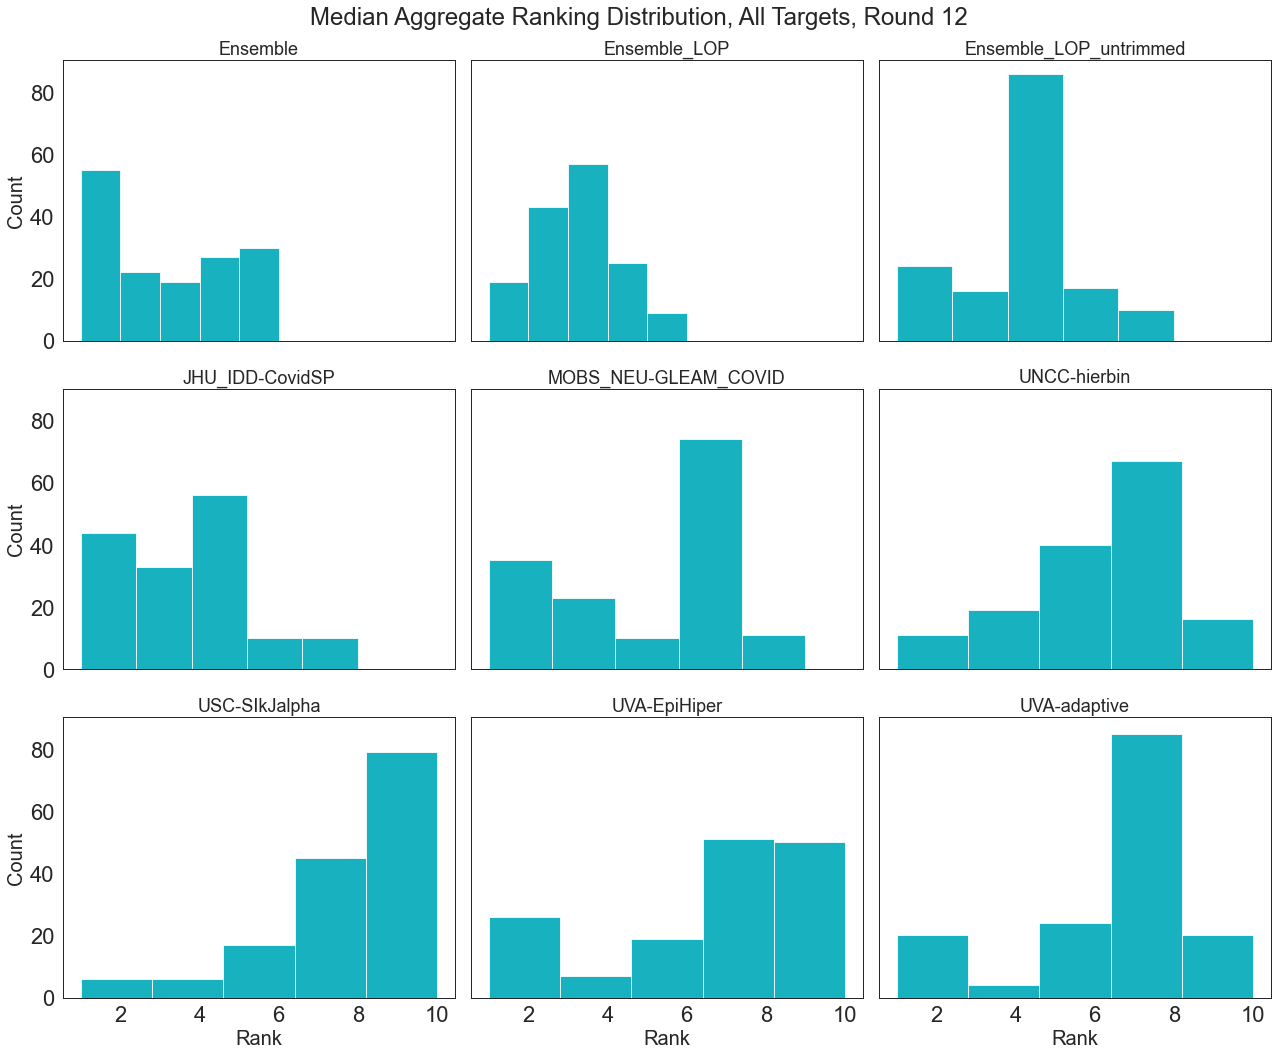

In [226]:
plt.rcParams.update({'axes.titlesize':'18'})
ax = dfrank_wisnorm_all.plot.hist( column='Rank', by='Model', bins=5, grid=False, figsize=(18,15), layout=(3,3), sharex=True,
                      sharey=True, color='#17B1BF', fontsize=22, legend=None)

for a in ax.flatten():
    a.set_xlabel("Rank", fontsize=20)
    a.set_ylabel("Count", fontsize=20)
    
plt.suptitle("Median Aggregate Ranking Distribution, All Targets, Round 12", fontsize=24)
plt.tight_layout()
plt.savefig('wisnorm_all_rd12_rankings.pdf')
plt.show()